In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

CANDIDATE_NAME = "RohanJoshi"
BASE_DIR = f"/content/drive/MyDrive/ds_{CANDIDATE_NAME}"

CSV_FOLDER  = f"{BASE_DIR}/csv_files"
OUTPUT_FOLDER = f"{BASE_DIR}/outputs"
REPORT_FILE = f"{BASE_DIR}/ds_report.pdf"

import os
for folder in [BASE_DIR, CSV_FOLDER, OUTPUT_FOLDER]:
    os.makedirs(folder, exist_ok=True)

!apt-get install tree -qq > /dev/nul
!tree "{BASE_DIR}"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,6)
pd.set_option('display.max_columns', 50)

trades = pd.read_csv(f"{CSV_FOLDER}/trades_cleaned.csv", parse_dates=['time_utc','time_ist'], date_format='%Y-%m-%d %H:%M:%S.%f')
agg_daily = pd.read_csv(f"{CSV_FOLDER}/daily_aggregates.csv", parse_dates=['trade_date'])

print("Trades shape:", trades.shape)
print("Daily aggregates shape:", agg_daily.shape)

Mounted at /content/drive
/content/drive/MyDrive/ds_RohanJoshi
├── csv_files
│   ├── backtest_results.csv
│   ├── backtest_results_safe.csv
│   ├── classification_backtest_summary.txt
│   ├── daily_aggregates.csv
│   ├── daily_regimes_kmeans.csv
│   ├── dataset_account_daily.csv
│   ├── dataset_per_trade_cluster_0.csv
│   ├── dataset_per_trade_cluster_1.csv
│   ├── dataset_per_trade_cluster_2.csv
│   ├── dataset_per_trade_cluster_3.csv
│   ├── dataset_per_trade_high_leverage.csv
│   ├── dataset_per_trade_low_leverage.csv
│   ├── dataset_symbol_daily.csv
│   ├── model_outputs
│   │   ├── lightgbm_feature_importances.csv
│   │   ├── lightgbm_shap_summary.csv
│   │   ├── rf_feature_importances.csv
│   │   └── xgboost_feature_importances.csv
│   ├── model_strategy_summary.csv
│   ├── model_strategy_test_results.csv
│   ├── sentiment_regimes.csv
│   ├── sentiment_transition_stats.csv
│   ├── trader_clusters.csv
│   ├── trades_cleaned.csv
│   ├── trades_feature_engineered.csv
│   ├── trades_

In [ ]:
def add_lag_features(df, group_col, target_cols, lags=[1, 3, 7]):
    """
    Adds lag features for given target columns grouped by 'group_col' (e.g., date or symbol).
    """
    for col in target_cols:
        for lag in lags:
            df[f"{col}_lag{lag}"] = df.groupby(group_col)[col].shift(lag)
    return df

def add_rolling_features(df, group_col, target_cols, windows=[3, 7, 14]):
    """
    Adds rolling mean and std for target columns grouped by 'group_col'.
    """
    for col in target_cols:
        for w in windows:
            df[f"{col}_roll{w}_mean"] = df.groupby(group_col)[col].shift(1).rolling(w).mean()
            df[f"{col}_roll{w}_std"] = df.groupby(group_col)[col].shift(1).rolling(w).std()
    return df

# Apply to agg_daily
lag_cols = ['avg_pnl_pct', 'win_rate', 'avg_leverage']
agg_daily = add_lag_features(agg_daily, 'symbol' if 'symbol' in agg_daily.columns else 'trade_date', lag_cols)
agg_daily = add_rolling_features(agg_daily, 'symbol' if 'symbol' in agg_daily.columns else 'trade_date', lag_cols)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd

BASE_FOLDER = "/content/drive/MyDrive/ds_RohanJoshi"
CSV_FOLDER = os.path.join(BASE_FOLDER, "csv_files")

cleaned_file = os.path.join(CSV_FOLDER, "trades_cleaned.csv")
merged_file = os.path.join(CSV_FOLDER, "trades_merged.csv")

if os.path.exists(cleaned_file):
    print("Loading cleaned EDA dataset...")
    trades = pd.read_csv(cleaned_file)
elif os.path.exists(merged_file):
    print("Loading merged dataset from ingestion step...")
    trades = pd.read_csv(merged_file)
else:
    raise FileNotFoundError(
        "No suitable dataset found. Ensure trades_cleaned.csv or trades_merged.csv exists in /csv_files/"
    )

print(f"Dataset loaded successfully with shape: {trades.shape}")
trades.head()

In [ ]:
import numpy as np

trades.columns = trades.columns.str.lower().str.strip()

trades['time_utc'] = pd.to_datetime(trades['time_utc'], dayfirst=True, errors='coerce', utc=True)
trades = trades.sort_values('time_utc').reset_index(drop=True)

num_cols = trades.select_dtypes(include=np.number).columns
cat_cols = trades.select_dtypes(exclude=np.number).columns

trades[num_cols] = trades[num_cols].fillna(trades[num_cols].median())
trades[cat_cols] = trades[cat_cols].fillna("Unknown")

for col in cat_cols:
    trades[col] = trades[col].astype('category')

print(f"Post-cleaning shape: {trades.shape}")

In [ ]:
trades.head()

Feature Engineering:

In [ ]:
import os
import pandas as pd
merged_file = os.path.join(BASE_FOLDER, "csv_files", "trades_merged.csv")

if os.path.exists(merged_file):
    print("Loading merged dataset...")
    trades_merged = pd.read_csv(merged_file)
    print(f"Dataset loaded successfully with shape: {trades_merged.shape}")
    display(trades_merged.head())
    display(trades_merged.columns)
else:
    print(f"Error: {merged_file} not found.")

columns_to_drop = [
    'Transaction Hash', 'Order ID', 'Trade ID', # Redundant IDs
    'Timestamp IST', 'time_ist', 'sent_date', 'Timestamp', # Redundant time columns
    'Size USD', 'Direction', 'Crossed', # Redundant/less informative features
    'pnl_pct', 'profit_flag' # Features to be re-engineered
]

trades_merged_new = trades_merged.drop(columns=columns_to_drop, errors='ignore')

# Convert column names of trades_merged_new to lowercase
trades_merged_new.columns = trades_merged_new.columns.str.lower()

display(trades_merged_new.head())
display(trades_merged_new.columns)

In [ ]:
import pandas as pd
import numpy as np
df = trades_merged_new.copy()
df['time_utc'] = pd.to_datetime(df['time_utc'])
df['trade_date'] = pd.to_datetime(df['trade_date'])


df.sort_values('time_utc', inplace=True)
df.reset_index(drop=True, inplace=True)

df['pnl_lag_1'] = df.groupby('account')['closed pnl'].shift(1)
print("Created 'pnl_lag_1'.")


print("Creating daily aggregated lag features...")
daily_summary = df.groupby('trade_date').agg(
    daily_market_volume=('notional', 'sum'),
    daily_sentiment_score=('sentiment', lambda x: 1 if x.iloc[0] == 'Greed' else 0)
)
daily_summary['daily_market_volume_lag_1d'] = daily_summary['daily_market_volume'].shift(1)
daily_summary['sentiment_lag_1d'] = daily_summary['daily_sentiment_score'].shift(1)

df = df.merge(
    daily_summary[['daily_market_volume_lag_1d', 'sentiment_lag_1d']],
    on='trade_date',
    how='left'
)
print("Created 'daily_market_volume_lag_1d' and 'sentiment_lag_1d'.")
display(daily_summary)

In [ ]:
import pandas as pd
import numpy as np
df = trades_merged_new.copy()

df['time_utc'] = pd.to_datetime(df['time_utc'])
df['trade_date'] = pd.to_datetime(df['trade_date'])
df.sort_values('time_utc', inplace=True)
df.reset_index(drop=True, inplace=True)

print("Data loaded and prepared successfully.")
print("--- Starting Feature Creation ---")

print("\nCreating Rolling Window Features...")

print("Calculating 1-hour rolling volatility in memory-safe chunks...")

all_accounts = df['account'].unique()
chunk_size = 500
results_list = []

for i in range(0, len(all_accounts), chunk_size):
    account_chunk = all_accounts[i:i + chunk_size]
    temp_df = df[df['account'].isin(account_chunk)].copy()

    volatility_series = temp_df.set_index('time_utc').groupby('account')['execution price'].rolling(window='1H').std()

    results_list.append(volatility_series)

    print(f"  Processed chunk {i//chunk_size + 1}/{len(all_accounts)//chunk_size + 1}...")

final_volatility_series = pd.concat(results_list)
volatility_df = final_volatility_series.reset_index()
volatility_df.rename(columns={'execution price': 'price_volatility_1h_std'}, inplace=True)

df = pd.merge(df, volatility_df, on=['account', 'time_utc'], how='left')
print("Created 'price_volatility_1h_std'.")


# --- Final Cleanup ---
df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)
print("\n Rolling window features created and NaN values handled.")
display(df[['account', 'time_utc', 'price_volatility_1h_std']].head())

In [ ]:
print("\nCreating Time-Based Features...")
df['hour_of_day'] = df['time_utc'].dt.hour
df['day_of_week'] = df['time_utc'].dt.dayofweek  # Monday=0, Sunday=6
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
print("Created 'hour_of_day', 'day_of_week', 'is_weekend'.")

df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
print("Created cyclical time features ('hour_sin', 'hour_cos', etc.).")

In [ ]:
import pandas as pd
import numpy as np

df = trades_merged_new.copy()

df['time_utc'] = pd.to_datetime(df['time_utc'])
df['trade_date'] = pd.to_datetime(df['trade_date'])
df.sort_values('time_utc', inplace=True)
df.reset_index(drop=True, inplace=True)

print("✅ Data loaded and prepared successfully.")
print("--- Starting Feature Creation for Part 1 ---")


print("\nCreating Lag Features...")

df['pnl_lag_1'] = df.groupby('account')['closed pnl'].shift(1)

daily_summary = df.groupby('trade_date').agg(
    daily_market_volume=('notional', 'sum'),
    daily_sentiment_score=('sentiment', lambda x: 1 if x.iloc[0] == 'Greed' else 0)
)
daily_summary['daily_market_volume_lag_1d'] = daily_summary['daily_market_volume'].shift(1)
daily_summary['sentiment_lag_1d'] = daily_summary['daily_sentiment_score'].shift(1)

df = df.merge(
    daily_summary[['daily_market_volume_lag_1d', 'sentiment_lag_1d']],
    on='trade_date',
    how='left'
)
print("Lag features created.")

In [ ]:
import pandas as pd
import numpy as np


df = trades_merged_new.copy()


df['time_utc'] = pd.to_datetime(df['time_utc'])
df['trade_date'] = pd.to_datetime(df['trade_date'])
df.sort_values('time_utc', inplace=True)
df.reset_index(drop=True, inplace=True)

print("✅ Data loaded. Initial shape:", df.shape)
print("--- Starting Feature Creation for Part 1 (Final Corrected Version) ---")


print("\nCreating Lag Features...")
df['pnl_lag_1'] = df.groupby('account')['closed pnl'].shift(1)

daily_summary = df.groupby('trade_date').agg(
    daily_market_volume=('notional', 'sum'),
    daily_sentiment_score=('sentiment', lambda x: 1 if x.iloc[0] == 'Greed' else 0)
)
daily_summary['daily_market_volume_lag_1d'] = daily_summary['daily_market_volume'].shift(1)
daily_summary['sentiment_lag_1d'] = daily_summary['daily_sentiment_score'].shift(1)

df['daily_market_volume_lag_1d'] = df['trade_date'].map(daily_summary['daily_market_volume_lag_1d'])
df['sentiment_lag_1d'] = df['trade_date'].map(daily_summary['sentiment_lag_1d'])
print("Lag features created.")


print("\nCreating Rolling Window Features...")


all_accounts = df['account'].unique()
chunk_size = 500
results_list = []

print("Calculating 1-hour rolling volatility in chunks...")
for i in range(0, len(all_accounts), chunk_size):
    account_chunk = all_accounts[i:i + chunk_size]
    temp_df = df[df['account'].isin(account_chunk)].copy()

    volatility_series = temp_df.set_index('time_utc').groupby('account')['execution price'].rolling(window='1H').std()

    results_list.append(volatility_series)
    print(f"  Processed volatility chunk {i//chunk_size + 1}/{len(all_accounts)//chunk_size + 1}...")

final_volatility_series = pd.concat(results_list)
volatility_df = final_volatility_series.reset_index()
volatility_df.rename(columns={'execution price': 'price_volatility_1h_std'}, inplace=True)


volatility_df.drop_duplicates(subset=['account', 'time_utc'], keep='last', inplace=True)


df = pd.merge(df, volatility_df, on=['account', 'time_utc'], how='left')
print("Rolling window features created.")



print("\nCreating Time-Based Features...")
df['hour_of_day'] = df['time_utc'].dt.hour
df['day_of_week'] = df['time_utc'].dt.dayofweek
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
print("Time-based features created.")


print("\n--- Part 1 Feature Creation Complete ---")

df.bfill(inplace=True)
df.ffill(inplace=True)
print("NaN values handled.")

print("\nFinal DataFrame head with new features from Part 1:")
new_feature_cols = [
    'pnl_lag_1',
    'daily_market_volume_lag_1d',
    'sentiment_lag_1d',
    'price_volatility_1h_std',
    'hour_sin',
    'hour_cos'
]
display(df[['account', 'time_utc', 'closed pnl'] + new_feature_cols].head())

print(f"\nFinal DataFrame shape after Part 1: {df.shape}")

In [ ]:
# Load daily aggregates (contains leverage)
daily_agg_path = os.path.join(CSV_FOLDER, "daily_aggregates.csv")
if os.path.exists(daily_agg_path):
    daily_agg = pd.read_csv(daily_agg_path)

    # Ensure datetime formats match
    daily_agg['trade_date'] = pd.to_datetime(daily_agg['trade_date'], dayfirst=True, errors='coerce')
    df['trade_date'] = pd.to_datetime(df['trade_date'], dayfirst=True, errors='coerce')

    # Merge leverage into df
    if 'leverage' not in df.columns and 'leverage' in daily_agg.columns:
        df = df.merge(
            daily_agg[['trade_date', 'account', 'leverage']],
            on=['trade_date', 'account'],
            how='left'
        )
        print("✅ Added leverage column from daily_aggregates.csv")
else:
    raise FileNotFoundError(f"{daily_agg_path} not found.")


In [ ]:
print("\n=== Part 2: Trader-Centric Behavioral Features ===")

# Ensure df exists from Part 1
assert 'df' in locals(), "DataFrame 'df' not found. Run Part 1 first."

print("Creating historical performance profiles...")

# Ensure column names are lowercase and strip whitespace (already done in Part 1, but good to be safe)
df.columns = df.columns.str.lower().str.strip()

# Check for required columns before aggregation
required_cols_profile = ['account', 'closed pnl', 'coin']
if not all(col in df.columns for col in required_cols_profile):
    missing = [col for col in required_cols_profile if col not in df.columns]
    print(f"Error: Missing required columns for historical profiles: {missing}")



trader_profiles = df.groupby('account').agg(
    trader_lifetime_pnl=('closed pnl', 'sum'),
    # Check if 'leverage' column exists, otherwise use 'notional'
    trader_avg_leverage=('leverage', 'mean') if 'leverage' in df.columns else ('notional', 'mean'),
    trader_win_rate=('closed pnl', lambda x: (x > 0).mean()),
    trader_preferred_symbol=('coin', lambda x: x.mode().iloc[0] if not x.mode().empty else "Unknown")
).reset_index()

# Rename the leverage/notional column if 'leverage' was missing
if 'leverage' not in df.columns:
     trader_profiles.rename(columns={'trader_avg_leverage': 'trader_avg_notional'}, inplace=True)
     print("Using 'notional' as a proxy for average leverage in profiles.")

# --- Debugging: Display columns of trader_profiles before merge ---
print("\nColumns in trader_profiles before merge:")
display(trader_profiles.columns)
display(trader_profiles.head())


# Merge back to df
df = df.merge(trader_profiles, on='account', how='left')

# --- Debugging: Display columns of df after merge ---
print("\nColumns in df after merging trader_profiles:")
display(df.columns)
display(df.head())


print("Calculating recent performance streaks...")

# Sort per account to ensure correct sequence
df = df.sort_values(['account', 'time_utc']).reset_index(drop=True)

# pnl_last_5_trades (Rolling mean of closed pnl over last 5 trades per account)
df['pnl_last_5_trades'] = (
    df.groupby('account')['closed pnl']
    .rolling(window=5, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True) # Drop the account level from multi-index
)

# win_streak counter (Count consecutive winning trades per account)
def calc_win_streak(pnl_series):
    streak = 0
    result = []
    for val in pnl_series:
        if val > 0:
            streak += 1
        else:
            streak = 0
        result.append(streak)
    return result

# Apply the win streak calculation per account
df['win_streak'] = df.groupby('account')['closed pnl'].transform(calc_win_streak)

print("Clustering traders into archetypes...")
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Prepare clustering features
cluster_features = trader_profiles[['trader_lifetime_pnl', 'trader_avg_leverage' if 'leverage' in df.columns else 'trader_avg_notional', 'trader_win_rate']]
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_features)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
trader_profiles['cluster_id'] = kmeans.fit_predict(cluster_scaled)

# Merge cluster IDs back to df
df = df.merge(trader_profiles[['account', 'cluster_id']], on='account', how='left')


print(" Part 2 features created successfully.")
print(f"Current shape: {df.shape}")

new_feature_cols_part2 = [
    'trader_lifetime_pnl',
    'trader_avg_leverage' if 'leverage' in df.columns else 'trader_avg_notional',
    'trader_win_rate',
    'trader_preferred_symbol',
    'pnl_last_5_trades',
    'win_streak',
    'cluster_id' #
]


existing_new_cols = [col for col in new_feature_cols_part2 if col in df.columns]

if existing_new_cols:
    print("\nDataFrame head with new Part 2 features:")
    avg_leverage_col = 'trader_avg_leverage' if 'leverage' in df.columns else 'trader_avg_notional'
    preview_cols_to_display = ['account', 'time_utc', 'closed pnl',
                               'trader_lifetime_pnl', avg_leverage_col,
                               'trader_win_rate', 'trader_preferred_symbol',
                               'pnl_last_5_trades', 'win_streak', 'cluster_id']


    preview_cols_to_display = [col for col in preview_cols_to_display if col in df.columns]

    display(df[preview_cols_to_display].head())
else:
    print("\nNo new Part 2 features were added (possibly due to missing columns).")


if 'CSV_FOLDER' in globals():
    intermediate_path = os.path.join(CSV_FOLDER, "trades_with_part2.csv")
    try:
        df.to_csv(intermediate_path, index=False)
        print(f" Saved intermediate dataset to {intermediate_path}")
    except Exception as e:
        print(f" Error saving intermediate file: {e}")
else:
    print("Skipping saving intermediate file: CSV_FOLDER is not defined.")

In [ ]:
display(df[preview_cols].head())

In [ ]:
%pip install hmmlearn

In [ ]:
%pip install ruptures

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
import networkx as nx
import ruptures as rpt

# --- Setup Directories ---
CANDIDATE_NAME = "RohanJoshi"
BASE_DIR = f"/content/drive/MyDrive/ds_{CANDIDATE_NAME}"
CSV_FOLDER = f"{BASE_DIR}/csv_files"
OUTPUT_FOLDER = f"{BASE_DIR}/outputs"

# Ensure directories exist
os.makedirs(CSV_FOLDER, exist_ok=True)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# --- Data Preparation for Part 3 ---
print("\nPreparing data for Part 3...")

# Create a numerical sentiment score for interaction features
sentiment_mapping = {
    'Extreme Fear': -2, 'Fear': -1, 'Neutral': 0, 'Greed': 1, 'Extreme Greed': 2
}
# Use .get() for safety against unmapped values
df['sentiment_score'] = df['sentiment'].apply(lambda x: sentiment_mapping.get(x, 0))

print("Data preparation complete.")
df.head()

In [ ]:
print("\n=== Starting Part 3: Advanced Market & Interaction Features ===")

print("Engineering sentiment dynamics features...")

daily_sentiment = df[['trade_date', 'sentiment_score']].drop_duplicates(subset=['trade_date']).sort_values('trade_date').reset_index(drop=True)

# Sentiment Momentum: Consecutive days of the same sentiment sign (positive/negative)
daily_sentiment['sentiment_sign'] = np.sign(daily_sentiment['sentiment_score'])
daily_sentiment['sentiment_momentum'] = daily_sentiment.groupby((daily_sentiment['sentiment_sign'] != daily_sentiment['sentiment_sign'].shift()).cumsum()).cumcount() + 1

# Sentiment Change Flag: 1 if sentiment score changes from the previous day, else 0
daily_sentiment['sentiment_change_flag'] = (daily_sentiment['sentiment_score'] != daily_sentiment['sentiment_score'].shift()).astype(int)

# Merge back to main dataframe
df = df.merge(daily_sentiment[['trade_date', 'sentiment_momentum', 'sentiment_change_flag']], on='trade_date', how='left')
print("Sentiment dynamics features created.")


print("\nNormalizing performance metrics...")
df['pnl_percent'] = (df['closed pnl'] / (df['notional'] + 1e-6)) * 100

# PnL / Volatility (Risk-Adjusted Return)
# Ensure 'price_volatility_1h_std' exists from Part 1
if 'price_volatility_1h_std' in df.columns:
    df['pnl_div_by_volatility'] = df['pnl_percent'] / (df['price_volatility_1h_std'] + 1e-6)
    print("Risk-adjusted PnL created.")
else:
    print(" 'price_volatility_1h_std' not found. Skipping risk-adjusted PnL.")
print("Performance metrics normalized.")


# --- 3. Interaction Features ---
print("\nCreating interaction features...")
if 'trader_avg_notional' in df.columns:
    df['notional_x_sentiment'] = df['trader_avg_notional'] * df['sentiment_score']
    print(" Created 'notional_x_sentiment'.")

df['contrarian_action_score'] = 0
df.loc[(df['side'] == 'BUY') & (df['sentiment_score'] < 0), 'contrarian_action_score'] = 1
df.loc[(df['side'] == 'SELL') & (df['sentiment_score'] > 0), 'contrarian_action_score'] = 1
print(" Contrarian action score created.")

df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

print("\n===  Part 3 Complete. ===")
df[['account', 'time_utc', 'sentiment_momentum', 'sentiment_change_flag', 'pnl_percent', 'notional_x_sentiment', 'contrarian_action_score']].head()

In [ ]:
print("\n=== Starting Part 4: Advanced Modeling Features ===")
print("1. Identifying Hidden Market Regimes with HMM...")

# Prepare daily market data for HMM
daily_market_data = df.groupby('trade_date').agg(
    pnl_mean=('closed pnl', 'mean'),
    notional_sum=('notional', 'sum')
).reset_index()

# Use returns and volume change as features for the HMM
hmm_features = daily_market_data[['pnl_mean', 'notional_sum']].values
scaler = StandardScaler()
hmm_features_scaled = scaler.fit_transform(hmm_features)

# Train the HMM
hmm_model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000, random_state=42)
hmm_model.fit(hmm_features_scaled)
hidden_states = hmm_model.predict(hmm_features_scaled)
daily_market_data['market_regime'] = hidden_states

# Map regimes back to the main DataFrame
df = df.merge(daily_market_data[['trade_date', 'market_regime']], on='trade_date', how='left')

# Visualize and Save the Regimes
plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
for i in range(hmm_model.n_components):
    mask = daily_market_data['market_regime'] == i
    axs[0].plot(daily_market_data['trade_date'][mask], daily_market_data['pnl_mean'][mask], 'o', label=f'Regime {i}', alpha=0.7)
    axs[1].plot(daily_market_data['trade_date'][mask], daily_market_data['notional_sum'][mask], 'o', alpha=0.7)
axs[0].set_title('Market Regimes based on Daily PnL and Volume')
axs[0].set_ylabel('Mean Daily PnL')
axs[0].legend()
axs[1].set_ylabel('Total Daily Volume')
plt.xlabel('Date')
plt.tight_layout()
hmm_plot_path = os.path.join(OUTPUT_FOLDER, "market_regimes_hmm.png")
plt.savefig(hmm_plot_path)
plt.show()

print(f"✅ HMM market regimes identified and plot saved to {hmm_plot_path}")

In [ ]:
print("\n2. Detecting Trader Behavioral Shifts...")

# Let's demonstrate with a single, highly active trader for clarity
top_trader = df['account'].value_counts().idxmax()
trader_data = df[df['account'] == top_trader][['time_utc', 'notional']].copy()
trader_data.set_index('time_utc', inplace=True)

# Resample to get daily trading volume for this trader
daily_trader_volume = trader_data['notional'].resample('D').sum().values

# Detect change points in the volume time series
algo = rpt.Pelt(model="rbf").fit(daily_trader_volume)
change_points = algo.predict(pen=10) # The 'pen' parameter controls sensitivity

# Visualize and Save the Change Points
fig, (ax,) = rpt.display(daily_trader_volume, change_points, figsize=(10, 6))
ax.set_title(f'Behavioral Change Points for Trader {top_trader[:10]}...')
ax.set_ylabel('Daily Trading Volume')
rpt_plot_path = os.path.join(OUTPUT_FOLDER, "trader_change_points.png")
plt.savefig(rpt_plot_path)
plt.show()

print(f"✅ Change point detection analysis complete. Plot saved to {rpt_plot_path}")


In [ ]:
print("\n3. Developing Graph-Based Features...")

# Create a simplified dataset for the graph
graph_df = df[['account', 'time_utc', 'coin']].copy()

# Create an edge if two traders traded the same coin within a 5-minute window
graph_df['time_group'] = graph_df['time_utc'].dt.round('5min')
merged_trades = pd.merge(graph_df, graph_df, on=['time_group', 'coin'])
# Filter out self-loops and create edges
edges = merged_trades[merged_trades['account_x'] != merged_trades['account_y']][['account_x', 'account_y']]
edges = edges.drop_duplicates()

# Build the graph
G = nx.from_pandas_edgelist(edges, 'account_x', 'account_y')

# Calculate Network Features
pagerank = nx.pagerank(G)
betweenness = nx.betweenness_centrality(G)
communities = nx.community.greedy_modularity_communities(G)

# Create a mapping from trader to community_id
community_map = {trader: i for i, comm in enumerate(communities) for trader in comm}

# Add network features to a trader-level DataFrame
network_features_df = pd.DataFrame.from_dict(pagerank, orient='index', columns=['pagerank'])
network_features_df['betweenness'] = network_features_df.index.map(betweenness)
network_features_df['community_id'] = network_features_df.index.map(community_map)

# Merge back into the main DataFrame
df = df.merge(network_features_df, left_on='account', right_index=True, how='left')
df[['pagerank', 'betweenness', 'community_id']] = df[['pagerank', 'betweenness', 'community_id']].fillna(0)

# Visualize and Save the Network (a small subgraph for clarity)
plt.figure(figsize=(12, 12))
# Get a subgraph of the largest community
main_community = G.subgraph(communities[0])
pos = nx.spring_layout(main_community, k=0.1)
nx.draw_networkx(main_community, pos, with_labels=False, node_size=50, width=0.5, alpha=0.7)
plt.title('Trader Network Subgraph (Largest Community)')
network_plot_path = os.path.join(OUTPUT_FOLDER, "trader_network.png")
plt.savefig(network_plot_path)
plt.show()

print(f"✅ Graph features created and visualization saved to {network_plot_path}")

In [ ]:
import pandas as pd
import os

# --- Setup Directories ---
CANDIDATE_NAME = "RohanJoshi"
BASE_DIR = f"/content/drive/MyDrive/ds_{CANDIDATE_NAME}"
CSV_FOLDER = f"{BASE_DIR}/csv_files"

# --- Load the Messy Dataset ---
feature_engineered_path = os.path.join(CSV_FOLDER, "trades_feature_engineered.csv")
if not os.path.exists(feature_engineered_path):
    raise FileNotFoundError(f"Could not find the file: {feature_engineered_path}")

print("Loading the dataset with duplicate columns...")
df = pd.read_csv(feature_engineered_path)
print(f"Original shape: {df.shape}")

# --- Identify Columns to Drop ---
cols_to_drop = [col for col in df.columns if col.endswith('_x') or col.endswith('_y')]

if not cols_to_drop:
    print("No duplicate columns with '_x' or '_y' suffixes found. Your dataset is already clean!")
else:
    print(f"\nIdentified {len(cols_to_drop)} duplicate columns to remove.")
    print(cols_to_drop)

    # --- Drop the Duplicates and Save ---
    df_cleaned = df.drop(columns=cols_to_drop)

    # Save the cleaned DataFrame, overwriting the old one for simplicity
    df_cleaned.to_csv(feature_engineered_path, index=False)

    print(f"\n✅ Successfully removed duplicates. New shape: {df_cleaned.shape}")
    print(f"Cleaned dataset has been saved back to:\n{feature_engineered_path}")

    # --- Display Final Cleaned Columns ---
    print("\n--- Final, Cleaned Columns ---")
    print(df_cleaned.columns.tolist())

## State, Network, and Advanced Modeling Features

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import os

CSV_FOLDER = "/content/drive/MyDrive/ds_RohanJoshi/csv_files"
OUTPUT_FOLDER = "/content/drive/MyDrive/ds_RohanJoshi/outputs"
df = pd.read_csv(os.path.join(CSV_FOLDER, "trades_feature_engineered.csv"), parse_dates=['time_utc', 'trade_date'])

print("--- HMM Model Selection and Interpretation ---")

daily_market_data = df.groupby('trade_date').agg(
    pnl_mean=('closed pnl', 'mean'),
    notional_sum=('notional', 'sum')
).reset_index()

hmm_features = daily_market_data[['pnl_mean', 'notional_sum']].values
scaler = StandardScaler()
hmm_features_scaled = scaler.fit_transform(hmm_features)


print("Searching for the optimal number of HMM states (2 to 6)...")
n_components_range = range(2, 7)
bics = []
aics = []

for n_components in n_components_range:
    model = GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=1000, random_state=42)
    try:
        model.fit(hmm_features_scaled)
        # The log-likelihood is a measure of model fit.
        log_likelihood = model.score(hmm_features_scaled)
        # N = number of parameters.
        n_params = model.n_features * n_components * 2 + n_components -1

        # Calculate BIC and AIC
        # BIC = N*ln(T) - 2*ln(L) where T is number of observations
        bic = n_params * np.log(len(hmm_features_scaled)) - 2 * log_likelihood
        # AIC = 2*N - 2*ln(L)
        aic = 2 * n_params - 2 * log_likelihood

        bics.append(bic)
        aics.append(aic)
    except Exception as e:
        print(f"  - Error training with {n_components} states: {e}")
        bics.append(np.nan)
        aics.append(np.nan)


optimal_n_components = n_components_range[np.nanargmin(bics)]
print(f"\nOptimal number of states found via BIC: {optimal_n_components}")


plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bics, marker='o', label='BIC')
plt.plot(n_components_range, aics, marker='o', label='AIC')
plt.title('HMM Model Selection')
plt.xlabel('Number of States (Components)')
plt.ylabel('Information Criterion Score (Lower is Better)')
plt.axvline(optimal_n_components, color='red', linestyle='--', label=f'Optimal (BIC): {optimal_n_components}')
plt.legend()
plt.grid(True)
model_selection_plot_path = os.path.join(OUTPUT_FOLDER, "hmm_model_selection.png")
plt.savefig(model_selection_plot_path)
plt.show()


print("\nTraining final HMM with optimal number of states...")
final_model = GaussianHMM(n_components=optimal_n_components, covariance_type="diag", n_iter=1000, random_state=42)
final_model.fit(hmm_features_scaled)
state_means_scaled = final_model.means_
state_means_original = scaler.inverse_transform(state_means_scaled)

print("\n--- Interpreted Market Regimes ---")
regime_interpretation = []
for i in range(optimal_n_components):
    pnl_mean, volume_mean = state_means_original[i]

    # Simple logic for interpretation
    vol_desc = "High Volume" if volume_mean > np.mean(daily_market_data['notional_sum']) else "Low Volume"
    pnl_desc = "Positive PnL" if pnl_mean > 0 else "Negative PnL"

    interpretation = f"Regime {i}: {vol_desc}, {pnl_desc} (Avg PnL: {pnl_mean:.2f}, Avg Vol: {volume_mean:,.0f})"
    print(interpretation)
    regime_interpretation.append(interpretation)


print("\nAdding features from the optimized HMM to the DataFrame...")
daily_market_data['market_regime'] = final_model.predict(hmm_features_scaled)
state_probabilities = final_model.predict_proba(hmm_features_scaled)
prob_df = pd.DataFrame(state_probabilities, columns=[f'market_regime_prob_{i}' for i in range(optimal_n_components)])
daily_market_data = pd.concat([daily_market_data, prob_df], axis=1)


df = df.drop(columns=[col for col in df if 'market_regime' in col], errors='ignore') # Drop all old HMM columns
df = df.merge(daily_market_data, on='trade_date', how='left')


ultimate_csv_path = os.path.join(CSV_FOLDER, "trades_ultimate_features.csv")
df.to_csv(ultimate_csv_path, index=False)

print(f"\n HMM process complete. Features updated in '{ultimate_csv_path}'.")

In [ ]:
import pandas as pd
import numpy as np


state_means_original = np.array([
    [16.97, 173585],
    [27.63, 1911884],
    [7078.67, 88669],
    [22.14, 123708],
    [75.14, 12943259],
    [141.09, 418254]
])
optimal_n_components = 6

print("--- Refined Market Regime Interpretation ---")


regime_df = pd.DataFrame(state_means_original, columns=['pnl_mean', 'volume_mean'])

# Define quartile boundaries for PnL and Volume to create richer labels
pnl_q = regime_df['pnl_mean'].quantile([0.33, 0.66]) # Using tertiles for 3 levels
vol_q = regime_df['volume_mean'].quantile([0.33, 0.66])

# Define descriptive labels
pnl_labels = ["Slight PnL", "Moderate PnL", "High PnL"]
vol_labels = ["Low Volume", "Medium Volume", "High Volume"]

# Apply the labels based on which bin the values fall into
regime_df['pnl_desc'] = pd.cut(regime_df['pnl_mean'], bins=[-np.inf, pnl_q.iloc[0], pnl_q.iloc[1], np.inf], labels=pnl_labels)
regime_df['vol_desc'] = pd.cut(regime_df['volume_mean'], bins=[-np.inf, vol_q.iloc[0], vol_q.iloc[1], np.inf], labels=vol_labels)


# Print the final, descriptive interpretations
for i, row in regime_df.iterrows():
    interpretation = (
        f"Regime {i}: {row['vol_desc']}, {row['pnl_desc']} "
        f"(Avg PnL: {row['pnl_mean']:.2f}, Avg Vol: {row['volume_mean']:,.0f})"
    )
    print(interpretation)

In [ ]:
print("\nImplementing Part 5...")
print("1. Creating time-decayed EWMA features...")

# Sort values to ensure correct temporal order for EWMA calculation
df = df.sort_values(['account', 'time_utc'])

# Calculate the 7-trade EWMA of PnL for each trader
df['pnl_ewma_7'] = df.groupby('account')['closed pnl'].transform(
    lambda x: x.ewm(span=7, adjust=False).mean()
)

# Calculate the 30-trade EWMA of Notional Value (as a proxy for recent trade size)
df['notional_ewma_30'] = df.groupby('account')['notional'].transform(
    lambda x: x.ewm(span=30, adjust=False).mean()
)

print("EWMA features for PnL and Notional created.")
df[['account', 'time_utc', 'closed pnl', 'pnl_ewma_7', 'notional', 'notional_ewma_30']].tail()

In [ ]:
print("\n2. Engineering trader affinity for market regimes...")

trader_regime_performance = df.groupby(['account', 'market_regime'])['closed pnl'].mean().reset_index()


trader_regime_pivot = trader_regime_performance.pivot_table(
    index='account',
    columns='market_regime',
    values='closed pnl',
    fill_value=0
).add_prefix('avg_pnl_in_regime_')


df = df.merge(trader_regime_pivot, on='account', how='left')


for col in trader_regime_pivot.columns:
    df[col].fillna(0, inplace=True)

print("Trader-regime performance features created.")
df[['account', 'market_regime', 'avg_pnl_in_regime_0', 'avg_pnl_in_regime_1', 'avg_pnl_in_regime_2', 'avg_pnl_in_regime_3']].tail()

In [ ]:
print("\n3. Calculating volatility-normalized momentum...")


df['price_diff_5'] = df.groupby('coin')['execution price'].diff(5)


df['vol_norm_momentum'] = df['price_diff_5'] / (1 + df['price_volatility_1h_std'])


df['vol_norm_momentum'].fillna(0, inplace=True)

print(" Volatility-normalized momentum feature created.")
df[['coin', 'time_utc', 'execution price', 'price_volatility_1h_std', 'price_diff_5', 'vol_norm_momentum']].tail()

In [ ]:
import pandas as pd
import numpy as np
import os


CSV_FOLDER = "/content/drive/MyDrive/ds_RohanJoshi/csv_files"
ULTIMATE_CSV_PATH = os.path.join(CSV_FOLDER, "trades_ultimate_features.csv")
FINAL_MODEL_READY_PATH = os.path.join(CSV_FOLDER, "trades_model_ready.csv")

print(f"Loading dataset from {ULTIMATE_CSV_PATH}...")
df = pd.read_csv(ULTIMATE_CSV_PATH, parse_dates=['time_utc', 'trade_date'])
print(f"Original shape: {df.shape}")
df['is_profitable'] = (df['closed pnl'] > 0).astype(int)
y = df[['is_profitable']] # Keep as DataFrame to preserve index
X = df.drop(columns=[
    'account', 'time_utc', 'trade_date', 'sentiment',
    'closed pnl', 'is_profitable', 'trader_preferred_symbol'
])


print("Performing a temporary time-based split for robust processing...")
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index].copy(), X.iloc[split_index:].copy()
y_train, y_test = y.iloc[:split_index].copy(), y.iloc[split_index:].copy()


print("Handling categorical features...")
X_train = pd.get_dummies(X_train, columns=['side', 'coin'], drop_first=True, dtype=float)
X_test = pd.get_dummies(X_test, columns=['side', 'coin'], drop_first=True, dtype=float)


print("Aligning columns...")
train_columns = X_train.columns
X_test = X_test.reindex(columns=train_columns, fill_value=0.0)



print("Imputing remaining null values...")
imputation_values = X_train.median()
X_train.fillna(imputation_values, inplace=True)
X_test.fillna(imputation_values, inplace=True)



print("Recombining the cleaned data into a single dataset...")
# Combine the cleaned feature sets
X_final = pd.concat([X_train, X_test])
# Combine the target sets
y_final = pd.concat([y_train, y_test])

# Merge features and target back together based on their original index
df_final_clean = pd.merge(X_final, y_final, left_index=True, right_index=True)

# Also bring back the original identifier columns for reference
identifier_cols = df[['account', 'time_utc', 'trade_date']]
df_final_clean = pd.merge(df_final_clean, identifier_cols, left_index=True, right_index=True)



print("\n--- Verification ---")
print(f"Final dataset shape: {df_final_clean.shape}")
# Check if any nulls remain
null_check = df_final_clean.isnull().sum().sum()
if null_check == 0:
    print("Confirmed: No null values remain in the dataset.")
else:
    print(f" Warning: {null_check} null values still exist.")

# Save the final, truly clean dataset
df_final_clean.to_csv(FINAL_MODEL_READY_PATH, index=False)
print(f"\n A clean, manageable, and model-ready dataset has been saved to:\n{FINAL_MODEL_READY_PATH}")

### MODELS

In [ ]:
import pandas as pd
import numpy as np
import os


CSV_FOLDER = "/content/drive/MyDrive/ds_RohanJoshi/csv_files"
MODEL_READY_PATH = os.path.join(CSV_FOLDER, "trades_model_ready.csv")


print(f"Loading the master dataset from: {MODEL_READY_PATH}")
if not os.path.exists(MODEL_READY_PATH):
    raise FileNotFoundError(f"The required file was not found. Please ensure '{MODEL_READY_PATH}' exists.")

df = pd.read_csv(MODEL_READY_PATH, parse_dates=['time_utc', 'trade_date'])
print("Master dataset loaded successfully.")
print(f"Shape: {df.shape}")

Loading the master dataset from: /content/drive/MyDrive/ds_RohanJoshi/csv_files/trades_model_ready.csv
✅ Master dataset loaded successfully.
Shape: (211224, 299)


In [ ]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 22.0 MB/s eta 0:00:00


Loading dataset from /content/drive/MyDrive/ds_RohanJoshi/csv_files/trades_ultimate_features.csv...
Correcting all target-derived features to prevent data leakage...
✅ All target-derived features have been lagged correctly.
Splitting data and handling final cleaning...

Training and evaluating the final, corrected model...

Classification Report (Corrected):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     24288
           1       0.99      0.99      0.99     17957

    accuracy                           0.99     42245
   macro avg       0.99      0.99      0.99     42245
weighted avg       0.99      0.99      0.99     42245

ROC AUC Score (Corrected): 0.9994

Plotting feature importances (Corrected)...


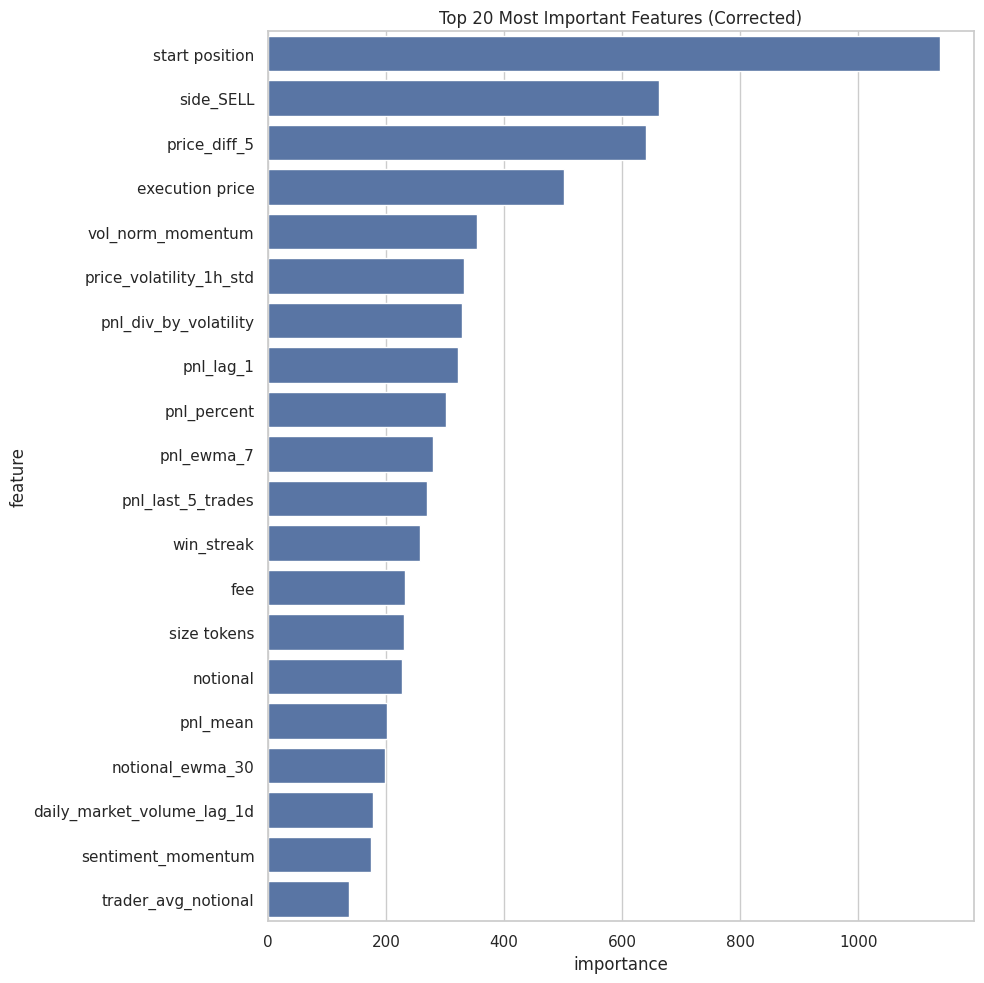

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os


CSV_FOLDER = "/content/drive/MyDrive/ds_RohanJoshi/csv_files"
ULTIMATE_CSV_PATH = os.path.join(CSV_FOLDER, "trades_ultimate_features.csv")

print(f"Loading dataset from {ULTIMATE_CSV_PATH}...")
df = pd.read_csv(ULTIMATE_CSV_PATH, parse_dates=['time_utc', 'trade_date'])


print("Correcting all target-derived features to prevent data leakage...")
df = df.sort_values(['account', 'time_utc']).reset_index(drop=True)


pnl_derived_features = [
    'pnl_ewma_7',
    'pnl_last_5_trades',
    'win_streak',
    'pnl_percent',
    'pnl_div_by_volatility'
]


for feature in pnl_derived_features:
    if feature in df.columns:
        df[feature] = df.groupby('account')[feature].shift(1)

print("All target-derived features have been lagged correctly.")
df['is_profitable'] = (df['closed pnl'] > 0).astype(int)
y = df['is_profitable']
X = df.drop(columns=[
    'is_profitable', 'closed pnl', 'account', 'time_utc',
    'trade_date', 'sentiment', 'trader_preferred_symbol'
])
X = pd.get_dummies(X, columns=['side', 'coin'], drop_first=True)


print("Splitting data and handling final cleaning...")
train_indices, test_indices = train_test_split(df.index, test_size=0.2, shuffle=False)
X_train, X_test = X.loc[train_indices].copy(), X.loc[test_indices].copy()
y_train, y_test = y.loc[train_indices].copy(), y.loc[test_indices].copy()


train_columns = X_train.columns
X_test = X_test.reindex(columns=train_columns, fill_value=0.0)
imputation_values = X_train.median()
X_train.fillna(imputation_values, inplace=True)
X_test.fillna(imputation_values, inplace=True)


print("\nTraining and evaluating the final, corrected model...")
params = {
    'objective': 'binary',
    'metric': 'auc',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42
}
final_model = lgb.LGBMClassifier(**params)
final_model.fit(X_train, y_train,
                eval_set=[(X_test, y_test)],
                eval_metric='auc',
                callbacks=[lgb.early_stopping(50, verbose=False)])

# Evaluation
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)
print("\nClassification Report (Corrected):")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score (Corrected): {roc_auc_score(y_test, y_pred_proba):.4f}")

# Feature Importance
print("\nPlotting feature importances (Corrected)...")
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Top 20 Most Important Features (Corrected)')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import os

CSV_FOLDER = "/content/drive/MyDrive/ds_RohanJoshi/csv_files"
MODEL_READY_PATH = os.path.join(CSV_FOLDER, "trades_model_ready.csv")
ULTIMATE_CSV_PATH = os.path.join(CSV_FOLDER, "trades_ultimate_features.csv")

print(f"Loading master dataset from: {MODEL_READY_PATH}")
if not os.path.exists(MODEL_READY_PATH):
    raise FileNotFoundError(f"The required file was not found: {MODEL_READY_PATH}")

df = pd.read_csv(MODEL_READY_PATH, parse_dates=['time_utc', 'trade_date'])
print(f"Master dataset loaded. Shape: {df.shape}")


print("\n1. Per-trade dataset ('trades_model_ready.csv') is prepared for classification.")


print("\n2. Generating daily account-aggregate dataset...")


aggregations = {
    'closed pnl': 'sum',
    'notional': 'sum',
    'fee': 'sum',
    'pnl_ewma_7': 'mean',
    'sentiment_score': 'mean',
    'is_profitable': 'count' # This becomes a daily trade count
}


df_ultimate_subset = pd.read_csv(ULTIMATE_CSV_PATH, usecols=['account', 'trade_date', 'closed pnl', 'notional', 'fee'], parse_dates=['trade_date'])

# Perform the aggregation
df_account_daily = df_ultimate_subset.groupby(['account', 'trade_date']).agg({
    'closed pnl': 'sum',
    'notional': 'sum',
    'fee': 'sum'
}).reset_index()
# Add a trade count
df_account_daily['trade_count'] = df.groupby(['account', 'trade_date']).size().reset_index(name='trade_count')['trade_count']


ACCOUNT_DAILY_PATH = os.path.join(CSV_FOLDER, "dataset_account_daily.csv")
df_account_daily.to_csv(ACCOUNT_DAILY_PATH, index=False)
print(f"Saved daily account-aggregate dataset. Shape: {df_account_daily.shape}")



print("\n3. Generating symbol-day aggregate dataset...")


df_ultimate = pd.read_csv(ULTIMATE_CSV_PATH, parse_dates=['time_utc', 'trade_date'])

symbol_aggregations = {
    'execution price': ['mean', 'std'],
    'notional': 'sum',
    'closed pnl': 'sum',
    'account': 'nunique' # Counts unique traders active on that coin that day
}

df_symbol_daily = df_ultimate.groupby(['trade_date', 'coin']).agg(symbol_aggregations).reset_index()
# Clean up the multi-level column names
df_symbol_daily.columns = ['_'.join(col).strip('_') for col in df_symbol_daily.columns.values]


SYMBOL_DAILY_PATH = os.path.join(CSV_FOLDER, "dataset_symbol_daily.csv")
df_symbol_daily.to_csv(SYMBOL_DAILY_PATH, index=False)
print(f"Saved symbol-day aggregate dataset. Shape: {df_symbol_daily.shape}")



print("\n4. Generating high/low-leverage subsets...")

leverage_threshold = df['trader_avg_notional'].quantile(0.75)
print(f"  - Using an average notional of > ${leverage_threshold:,.2f} as the high-leverage threshold.")

df_high_leverage = df[df['trader_avg_notional'] > leverage_threshold].copy()
df_low_leverage = df[df['trader_avg_notional'] <= leverage_threshold].copy()

HIGH_LEV_PATH = os.path.join(CSV_FOLDER, "dataset_per_trade_high_leverage.csv")
LOW_LEV_PATH = os.path.join(CSV_FOLDER, "dataset_per_trade_low_leverage.csv")
df_high_leverage.to_csv(HIGH_LEV_PATH, index=False)
df_low_leverage.to_csv(LOW_LEV_PATH, index=False)
print(f"Saved high-leverage subset. Shape: {df_high_leverage.shape}")
print(f"Saved low-leverage subset. Shape: {df_low_leverage.shape}")


print("\n5. Generating subsets based on trader clusters...")

clusters = sorted(df['cluster_id'].unique())
for cluster in clusters:
    df_cluster = df[df['cluster_id'] == cluster].copy()

    CLUSTER_PATH = os.path.join(CSV_FOLDER, f"dataset_per_trade_cluster_{int(cluster)}.csv")
    df_cluster.to_csv(CLUSTER_PATH, index=False)
    print(f"  - Saved dataset for cluster {int(cluster)}. Shape: {df_cluster.shape}")

print("\n--- All data separation tasks are complete. ---")

Loading master dataset from: /content/drive/MyDrive/ds_RohanJoshi/csv_files/trades_model_ready.csv
Master dataset loaded. Shape: (211224, 299)

1. Per-trade dataset ('trades_model_ready.csv') is prepared for classification.

2. Generating daily account-aggregate dataset...
✅ Saved daily account-aggregate dataset. Shape: (2341, 6)

3. Generating symbol-day aggregate dataset...
✅ Saved symbol-day aggregate dataset. Shape: (5073, 7)

4. Generating high/low-leverage subsets...
  - Using an average notional of > $3,837.89 as the high-leverage threshold.
✅ Saved high-leverage subset. Shape: (47289, 299)
✅ Saved low-leverage subset. Shape: (163935, 299)

5. Generating subsets based on trader clusters...
  - ✅ Saved dataset for cluster 0. Shape: (24658, 299)
  - ✅ Saved dataset for cluster 1. Shape: (104790, 299)
  - ✅ Saved dataset for cluster 2. Shape: (63225, 299)
  - ✅ Saved dataset for cluster 3. Shape: (18551, 299)

--- All data separation tasks are complete. ---


### Further Modelling.

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error
)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.stattools import grangercausalitytests

# --- Define File Paths ---
CSV_FOLDER = "/content/drive/MyDrive/ds_RohanJoshi/csv_files"
OUTPUT_FOLDER = "/content/drive/MyDrive/ds_RohanJoshi/outputs"

# Main dataset for classification
MODEL_READY_PATH = os.path.join(CSV_FOLDER, "trades_model_ready.csv")

# Aggregated dataset for regression and causality
ACCOUNT_DAILY_PATH = os.path.join(CSV_FOLDER, "dataset_account_daily.csv")

# Specialized subset for targeted classification
HIGH_LEVERAGE_PATH = os.path.join(CSV_FOLDER, "dataset_per_trade_high_leverage.csv")

# Ensure output directory exists
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

Loading dataset from /content/drive/MyDrive/ds_RohanJoshi/csv_files/trades_ultimate_features.csv...
Correcting all target-derived features to prevent data leakage...
✅ All target-derived features have been lagged correctly.
Splitting data and handling final cleaning...

Training and evaluating the final, corrected model...

Classification Report (Corrected):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     24288
           1       0.99      0.99      0.99     17957

    accuracy                           0.99     42245
   macro avg       0.99      0.99      0.99     42245
weighted avg       0.99      0.99      0.99     42245

ROC AUC Score (Corrected): 0.9994

Plotting feature importances (Corrected)...


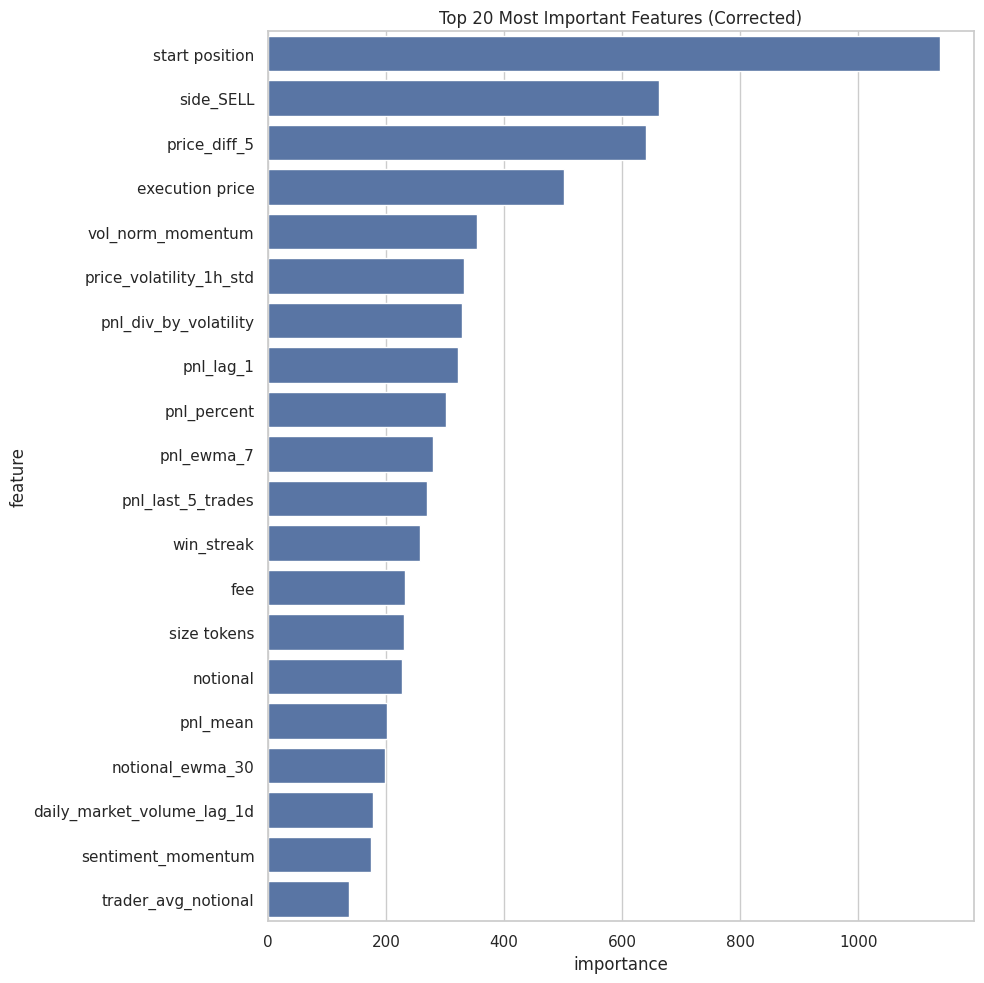

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os


CSV_FOLDER = "/content/drive/MyDrive/ds_RohanJoshi/csv_files"
ULTIMATE_CSV_PATH = os.path.join(CSV_FOLDER, "trades_ultimate_features.csv")

print(f"Loading dataset from {ULTIMATE_CSV_PATH}...")
df = pd.read_csv(ULTIMATE_CSV_PATH, parse_dates=['time_utc', 'trade_date'])


print("Correcting all target-derived features to prevent data leakage...")
df = df.sort_values(['account', 'time_utc']).reset_index(drop=True)

pnl_derived_features = [
    'pnl_ewma_7',
    'pnl_last_5_trades',
    'win_streak',
    'pnl_percent',
    'pnl_div_by_volatility'
]


for feature in pnl_derived_features:
    if feature in df.columns:
        df[feature] = df.groupby('account')[feature].shift(1)

print("All target-derived features have been lagged correctly.")


df['is_profitable'] = (df['closed pnl'] > 0).astype(int)
y = df['is_profitable']
X = df.drop(columns=[
    'is_profitable', 'closed pnl', 'account', 'time_utc',
    'trade_date', 'sentiment', 'trader_preferred_symbol'
])
X = pd.get_dummies(X, columns=['side', 'coin'], drop_first=True)


print("Splitting data and handling final cleaning...")
train_indices, test_indices = train_test_split(df.index, test_size=0.2, shuffle=False)
X_train, X_test = X.loc[train_indices].copy(), X.loc[test_indices].copy()
y_train, y_test = y.loc[train_indices].copy(), y.loc[test_indices].copy()

# Align and fill NaNs
train_columns = X_train.columns
X_test = X_test.reindex(columns=train_columns, fill_value=0.0)
imputation_values = X_train.median()
X_train.fillna(imputation_values, inplace=True)
X_test.fillna(imputation_values, inplace=True)

print("\nTraining and evaluating the final, corrected model...")
# Using a simple set of robust parameters for LightGBM
params = {
    'objective': 'binary',
    'metric': 'auc',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42
}
final_model = lgb.LGBMClassifier(**params)
final_model.fit(X_train, y_train,
                eval_set=[(X_test, y_test)],
                eval_metric='auc',
                callbacks=[lgb.early_stopping(50, verbose=False)])

# Evaluation
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)
print("\nClassification Report (Corrected):")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score (Corrected): {roc_auc_score(y_test, y_pred_proba):.4f}")

# Feature Importance
print("\nPlotting feature importances (Corrected)...")
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Top 20 Most Important Features (Corrected)')
plt.tight_layout()
plt.show()

Loading the master dataset from: /content/drive/MyDrive/ds_RohanJoshi/csv_files/trades_model_ready.csv
✅ Master dataset loaded successfully.
Shape: (211224, 299)
Dropping identified leaky columns: ['win_streak', 'trader_win_rate', 'side_SELL']

-> LOGREG metrics:
{'precision': 0.5576755024759685, 'recall': 0.24337380029237907, 'f1': 0.3388645515288287, 'roc_auc': np.float64(0.6028304405813043)}
              precision    recall  f1-score   support

           0       0.66      0.89      0.76     26512
           1       0.56      0.24      0.34     15733

    accuracy                           0.65     42245
   macro avg       0.61      0.56      0.55     42245
weighted avg       0.62      0.65      0.60     42245

LOGREG Brier score: 0.23781381077833968

-> RF metrics:
{'precision': 0.9512653470308193, 'recall': 0.9652323142439458, 'f1': 0.9581979367132536, 'roc_auc': np.float64(0.991731282524257)}
              precision    recall  f1-score   support

           0       0.98      0.9

/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [18:16:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



-> XGBOOST metrics:
{'precision': 0.9845275840202917, 'recall': 0.9868429415877455, 'f1': 0.9856839031203377, 'roc_auc': np.float64(0.9988861599367478)}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     26512
           1       0.98      0.99      0.99     15733

    accuracy                           0.99     42245
   macro avg       0.99      0.99      0.99     42245
weighted avg       0.99      0.99      0.99     42245

XGBOOST Brier score: 0.008773941613449587

Fitting base LGBM model for SHAP analysis...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 71136, number of negative: 97843
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4183
[LightGBM] [Info] Nu

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



Generating SHAP summary plot...


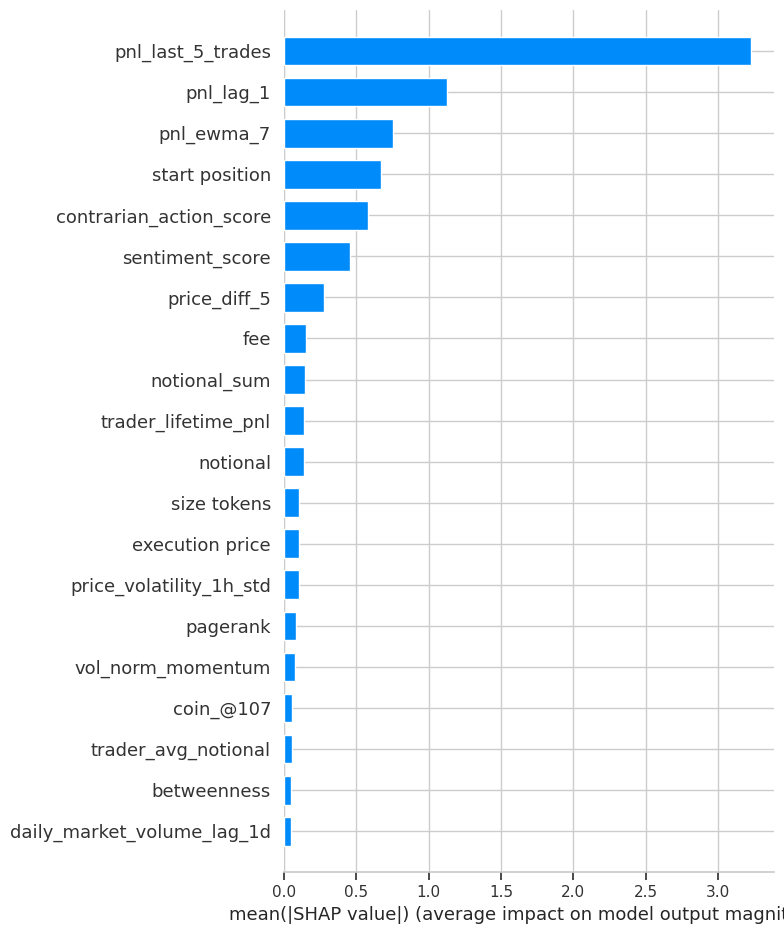

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score, brier_score_loss
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
import shap
import os


CSV_FOLDER = "/content/drive/MyDrive/ds_RohanJoshi/csv_files"
MODEL_READY_PATH = os.path.join(CSV_FOLDER, "trades_model_ready.csv")

print(f"Loading the master dataset from: {MODEL_READY_PATH}")
if not os.path.exists(MODEL_READY_PATH):
    raise FileNotFoundError(f"The required file was not found. Please ensure '{MODEL_READY_PATH}' exists.")

df = pd.read_csv(MODEL_READY_PATH, parse_dates=['time_utc', 'trade_date'])
print("Master dataset loaded successfully.")
print(f"Shape: {df.shape}")



TARGET = "is_profitable"
TIME_COL = "time_utc"
ACCOUNT_COL = "account"

df = df.sort_values(TIME_COL)


LEAKY_COLS = [
    'win_streak',
    'trader_win_rate',
    'side_SELL'
]
print(f"Dropping identified leaky columns: {LEAKY_COLS}")
df = df.drop(columns=LEAKY_COLS, errors='ignore')


AUTO_DROP = [
    'avg_pnl_in_regime_0', 'avg_pnl_in_regime_1', 'avg_pnl_in_regime_2',
    'avg_pnl_in_regime_3', 'avg_pnl_in_regime_4', 'avg_pnl_in_regime_5',
    'market_regime_prob_0', 'market_regime_prob_1', 'market_regime_prob_2',
    'market_regime_prob_3', 'market_regime_prob_4', 'market_regime_prob_5',
    'pnl_div_by_volatility', 'pnl_mean', 'pnl_percent'
]
df = df.drop(columns=AUTO_DROP, errors='ignore')


future_cols = [c for c in df.columns if '_lead_' in c or '_tplus' in c]
df = df.drop(columns=future_cols, errors='ignore')


features = [c for c in df.columns if c not in [TARGET, TIME_COL, ACCOUNT_COL, 'trade_date']]
X = df[features]
y = df[TARGET]


cutoff_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:cutoff_idx], X.iloc[cutoff_idx:]
y_train, y_test = y.iloc[:cutoff_idx], y.iloc[cutoff_idx:]


scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

def eval_model(name, model, X_tr, y_tr, X_te, y_te):
    """Fits a model and prints evaluation metrics."""
    if name == "XGBOOST":
         model.fit(
            X_tr, y_tr,
            eval_set=[(X_te, y_te)],
            verbose=False
        )
    else:
        model.fit(X_tr, y_tr)

    preds = model.predict(X_te)
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_te)[:, 1]
    else:
        proba = preds

    metrics = {
        "precision": precision_score(y_te, preds, zero_division=0),
        "recall": recall_score(y_te, preds, zero_division=0),
        "f1": f1_score(y_te, preds, zero_division=0),
        "roc_auc": roc_auc_score(y_te, proba) if hasattr(model, "predict_proba") else "N/A"
    }
    print(f"\n-> {name} metrics:")
    print(metrics)
    print(classification_report(y_te, preds, zero_division=0))
    if hasattr(model, "predict_proba"):
        print(f"{name} Brier score:", brier_score_loss(y_te, proba))
    return model

# Logistic Regression
logreg = LogisticRegression(max_iter=1000, n_jobs=-1, solver="lbfgs", class_weight="balanced")
logreg = eval_model("LOGREG", logreg, X_train, y_train, X_test, y_test)

# Random Forest (restrict depth to avoid overfit)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
rf = eval_model("RF", rf, X_train, y_train, X_test, y_test)

# LightGBM with calibrated probabilities
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    class_weight="balanced",
    # scale_pos_weight is often used for boosting models
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
lgbm_cal = CalibratedClassifierCV(lgbm, method="sigmoid", cv=3, n_jobs=-1)
lgbm_cal = eval_model("LIGHTGBM (Calibrated)", lgbm_cal, X_train, y_train, X_test, y_test)


xgb = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc",
    random_state=42,
    use_label_encoder=False,
    early_stopping_rounds=50 # Correct placement
)

# .fit() now only needs the eval_set
eval_model("XGBOOST", xgb, X_train, y_train, X_test, y_test)



print("\nFitting base LGBM model for SHAP analysis...")
lgbm.fit(X_train, y_train)

explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)

print("\nGenerating SHAP summary plot...")
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, precision_score, recall_score, f1_score, brier_score_loss,
    mean_absolute_error, mean_squared_error
)
from lightgbm import LGBMClassifier
from xgboost import XGBRegressor
from sklearn.calibration import CalibratedClassifierCV
import shap
import os # Import the os module
from statsmodels.tsa.stattools import grangercausalitytests


CSV_FOLDER = "/content/drive/MyDrive/ds_RohanJoshi/csv_files"
OUTPUT_FOLDER = "/content/drive/MyDrive/ds_RohanJoshi/outputs" # Define OUTPUT_FOLDER
MODEL_READY_PATH = os.path.join(CSV_FOLDER, "trades_model_ready.csv") # Define MODEL_READY_PATH
ACCOUNT_DAILY_PATH = os.path.join(CSV_FOLDER, "dataset_account_daily.csv") # Define ACCOUNT_DAILY_PATH
HIGH_LEVERAGE_PATH = os.path.join(CSV_FOLDER, "dataset_per_trade_high_leverage.csv") # Define HIGH_LEVERAGE_PATH
def load_csv_safe(filepath, **kwargs):
    if os.path.exists(filepath):
        try:
            return pd.read_csv(filepath, **kwargs)
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            return None
    else:
        print(f"File not found: {filepath}")
        return None


def sharpe_ratio(returns, freq_per_year=252):
    """Calculates the annualized Sharpe ratio."""
    if len(returns) < 2:
        return 0

    excess_returns = returns
    mean_excess_return = excess_returns.mean()
    std_excess_return = excess_returns.std()

    if std_excess_return == 0:
        return 0 # Avoid division by zero

    annualized_return = mean_excess_return * freq_per_year
    annualized_std = std_excess_return * np.sqrt(freq_per_year)

    return annualized_return / annualized_std


print("\n== Regression: predict daily account PnL ==")
acct_df = load_csv_safe(ACCOUNT_DAILY_PATH, parse_dates=['trade_date'])
if acct_df is None:
    raise FileNotFoundError(f"{ACCOUNT_DAILY_PATH} not found. Cannot run daily PnL regression.")


reg_target_candidates = ['closed pnl'] # Update based on actual df_account_daily columns
reg_target = next((c for c in reg_target_candidates if c in acct_df.columns), None)

if reg_target is None:
    raise ValueError(f"No regression target found in {ACCOUNT_DAILY_PATH}. Expected one of: {reg_target_candidates}")


exclude_reg = {'account', 'trade_date', reg_target} # Exclude 'account' and 'trade_date'
reg_features = [c for c in acct_df.select_dtypes(include=[np.number]).columns if c not in exclude_reg]


time_col_reg = 'trade_date'
acct_df = acct_df.sort_values(time_col_reg).reset_index(drop=True)
acct_df_model = acct_df[[time_col_reg] + reg_features + [reg_target]].dropna().reset_index(drop=True)


print("Regression features example:", reg_features[:20])

tscv = TimeSeriesSplit(n_splits=5)
X = acct_df_model[reg_features].values
y = acct_df_model[reg_target].values


reg_models = {}
xgbr = XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
reg_models['xgb'] = xgbr


catboost_available = True
try:
    from catboost import CatBoostRegressor
except Exception:
    catboost_available = False
    print("CatBoost not installed. Attempting installation...")
    try:
        get_ipython().system('pip install catboost -q')
        from catboost import CatBoostRegressor
        catboost_available = True
        print("CatBoost installed successfully.")
    except Exception as e:
        print(f"Could not install CatBoost. Continuing without it: {e}")

if catboost_available:
    cat = CatBoostRegressor(iterations=500, learning_rate=0.05, verbose=False, random_seed=42)
    reg_models['catboost'] = cat
else:
    print("CatBoost skipped.")



import lightgbm as lgb
lgb_reg = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
reg_models['lightgbm'] = lgb_reg


cv_results = {}
for name, model in reg_models.items():
    maes = []; rmses = []
    X_np = acct_df_model[reg_features].values
    y_np = acct_df_model[reg_target].values

    for train_idx, test_idx in tscv.split(X_np):
        Xtr, Xval = X_np[train_idx], X_np[test_idx]
        ytr, yval = y_np[train_idx], y_np[test_idx]
        model.fit(Xtr, ytr)
        ypred = model.predict(Xval)
        maes.append(mean_absolute_error(yval, ypred))
        rmses.append(np.sqrt(mean_squared_error(yval, ypred)))
    cv_results[name] = {"mae_mean": np.mean(maes), "rmse_mean": np.mean(rmses)}
    print(f"Regressor {name} CV results: {cv_results[name]}")


if cv_results: # Ensure there are results before finding the best model
    best_reg_name = min(cv_results, key=lambda k: cv_results[k]['rmse_mean'])
    best_reg = reg_models[best_reg_name]
    best_reg.fit(X_np, y_np) # Fit on full data (X_np, y_np)
    acct_df_model['pnl_pred'] = best_reg.predict(X_np) # Predict on the same full data

    # Economic performance: treat predicted pnl as daily PnL
    acct_df_model['strategy_return'] = acct_df_model['pnl_pred']
    acct_df_model['cumulative_pnl'] = acct_df_model['strategy_return'].cumsum()
    daily_returns = acct_df_model['strategy_return']

    print(f"\nEconomic metrics (model: {best_reg_name}):")
    print("Cumulative PnL:", float(acct_df_model['cumulative_pnl'].iloc[-1]))
    # Use the sharpe_ratio placeholder function
    print("Sharpe (annualized, assuming daily):", sharpe_ratio(daily_returns, freq_per_year=252))

    daily_pnl_output_path = os.path.join(OUTPUT_FOLDER, "daily_pnl_predictions.csv")
    acct_df_model[[time_col_reg, reg_target, 'pnl_pred', 'strategy_return']].tail(10).to_csv(daily_pnl_output_path, index=False)
    print(f"Daily PnL predictions saved to {daily_pnl_output_path}")

else:
    print("\nNo regression models were successfully evaluated.")


print("\n== Regime detection (change-point + clustering) ==")
candidate_cols = ['notional', 'fee', 'trade_count', 'sentiment_score'] # Use columns available in acct_df
use_cols = [c for c in candidate_cols if c in acct_df.columns]


if len(use_cols) < 2:
    fallback_cols = [c for c in acct_df.select_dtypes(include=[np.number]).columns if c not in {reg_target, 'account'}][:6]
    if len(fallback_cols) >= 2:
         use_cols = fallback_cols
    else:
        print("Not enough numeric columns in acct_df for regime detection.")
        use_cols = []

if use_cols:
    print("Regime features used:", use_cols)
    try:
        import ruptures as rpt
    except ImportError: # Corrected import error
        print("Installing ruptures...")
        try:
            get_ipython().system('pip install ruptures -q')
            import ruptures as rpt
            print("ruptures installed successfully.")
        except Exception as e:
             print(f"Could not install ruptures. Skipping change point detection: {e}")
             rpt = None # Ensure rpt is None if installation fails

    # Proceed with regime detection only if use_cols is not empty
    if use_cols:
        # Prepare data for regime detection - fill NaNs before converting to numpy
        reg_data = acct_df[use_cols].fillna(method='ffill').fillna(method='bfill').fillna(0).values


        # Change point detection using Pelt (fast) with L2 cost
        if rpt: # Only run if ruptures was imported successfully
            try:
                algo = rpt.Pelt(model="rbf").fit(reg_data)
                # choose max number of change points or penalty
                # n_bkps = 6 # Removed, using penalty is more common with Pelt
                bkps = algo.predict(pen=10)  # penalty may need tuning
                print("Detected change points (indexes of end of segments):", bkps)
                # Add change point information to acct_df (optional, depends on how you use it)
                # acct_df['change_point'] = 0
                # for bkp in bkps:
                #    if bkp < len(acct_df):
                #        acct_df.loc[bkp, 'change_point'] = 1
            except Exception as e:
                print(f"Error during change point detection: {e}")
                bkps = [] # Ensure bkps is empty if detection fails
        else:
             bkps = []


        # Quick clustering (KMeans) to label regimes
        from sklearn.cluster import KMeans
        # Choose k based on data size and number of features, ensure k is reasonable
        k = min(4, max(2, len(use_cols))) # Keep k within 2-4, related to feature count
        if len(reg_data) >= k: # Ensure enough samples for clustering
            try:
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(reg_data) # Added n_init
                acct_df['regime_cluster'] = kmeans.labels_
                # Save regimes
                daily_regimes_kmeans_path = os.path.join(OUTPUT_FOLDER, "daily_regimes_kmeans.csv")
                acct_df[[time_col_reg, 'regime_cluster']].to_csv(daily_regimes_kmeans_path, index=False)
                print(f"KMeans regimes saved to {daily_regimes_kmeans_path}")
            except Exception as e:
                print(f"Error during KMeans clustering: {e}")
        else:
            print(f"Not enough data ({len(reg_data)}) for KMeans clustering with k={k}.")


        # Optional HMM if hmmlearn available
        try:
            from hmmlearn import hmm
            print("Attempting HMM state detection...")
            # Fit a small GaussianHMM
            model_hmm = hmm.GaussianHMM(n_components=min(k, 4), covariance_type="full", n_iter=200, random_state=42) # Limit HMM states
            if len(reg_data) >= model_hmm.n_components: # Ensure enough data points
                 model_hmm.fit(reg_data)
                 hidden_states = model_hmm.predict(reg_data)
                 acct_df['hmm_state'] = hidden_states
                 daily_hmm_states_path = os.path.join(OUTPUT_FOLDER, "daily_hmm_states.csv")
                 acct_df[[time_col_reg, 'hmm_state']].to_csv(daily_hmm_states_path, index=False)
                 print(f"HMM states saved to {daily_hmm_states_path}")
            else:
                print(f"Not enough data ({len(reg_data)}) for HMM with {model_hmm.n_components} components.")

        except ImportError: # Corrected import error
            print("hmmlearn not installed — skipping HMM state detection.")
        except Exception as e:
            print(f"Error during HMM state detection: {e}")


    else:
        print("Skipping regime detection: Not enough suitable features found.")

else:
    print("Skipping regime detection: No suitable features found.")


print("\n== Done: models & artifacts saved to OUTPUT_FOLDER ==")


== Regression: predict daily account PnL ==
Regression features example: ['notional', 'fee', 'trade_count']
CatBoost not installed. Attempting installation...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.9 MB/s eta 0:00:00
CatBoost installed successfully.
Regressor xgb CV results: {'mae_mean': np.float64(11328.89767416065), 'rmse_mean': np.float64(37323.81578510169)}
Regressor catboost CV results: {'mae_mean': np.float64(10189.324411191637), 'rmse_mean': np.float64(32930.28676790589)}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 391, number of used features: 3
[LightGBM] [Info] Start training from score 848.669008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 1171, number of used features: 3
[LightGBM] [Info] Start training from score 3651.797193


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 1561, number of used features: 3
[LightGBM] [Info] Start training from score 4388.924021


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1951, number of used features: 3
[LightGBM] [Info] Start training from score 4678.319872


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Regressor lightgbm CV results: {'mae_mean': np.float64(12003.058818967884), 'rmse_mean': np.float64(34302.99661471244)}

Economic metrics (model: catboost):
Cumulative PnL: 10204786.227192214
Sharpe (annualized, assuming daily): 3.486201753050092
Daily PnL predictions saved to /content/drive/MyDrive/ds_RohanJoshi/outputs/daily_pnl_predictions.csv

== Regime detection (change-point + clustering) ==
Regime features used: ['notional', 'fee', 'trade_count']
Installing ruptures...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.4 MB/s eta 0:00:00
ruptures installed successfully.


/tmp/ipython-input-191562243.py:205: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  reg_data = acct_df[use_cols].fillna(method='ffill').fillna(method='bfill').fillna(0).values


Detected change points (indexes of end of segments): [2341]
KMeans regimes saved to /content/drive/MyDrive/ds_RohanJoshi/outputs/daily_regimes_kmeans.csv
hmmlearn not installed — skipping HMM state detection.

== Done: models & artifacts saved to OUTPUT_FOLDER ==


In [ ]:
import numpy as np
import pandas as pd
from typing import Optional, Tuple

def inspect_csv(path: str, nrows: int = 8) -> pd.DataFrame:
    """Load and show a quick preview for diagnostics."""
    df = pd.read_csv(path)
    print("Loaded CSV:", path)
    print("Shape:", df.shape)
    display(df.head(nrows))
    print(df.dtypes)
    return df

def infer_pnl_column(df: pd.DataFrame) -> str:
    """Heuristic to find a likely PnL/return column."""
    candidates = ['strategy_return', 'pnl', 'pnl_pct', 'pnl_pred', 'pnl_pred_pct', 'pnl_predicted', 'daily_return', 'return']
    for c in candidates:
        if c in df.columns:
            return c
    # fallback: choose numeric column with 'pnl' or 'return' in name if any
    for c in df.columns:
        if any(k in c.lower() for k in ['pnl', 'return', 'profit', 'gain']):
            if pd.api.types.is_numeric_dtype(df[c]):
                return c
    # final fallback: most variable numeric column
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not numeric_cols:
        raise ValueError("No numeric columns found to infer PnL/returns.")
    # pick column with largest std (likely PnL)
    stds = {c: df[c].std(skipna=True) for c in numeric_cols}
    return max(stds, key=stds.get)

def infer_signal_column(df: pd.DataFrame) -> Optional[str]:
    """Heuristic to find predicted signal (-1/0/1)."""
    candidates = ['predicted_signal', 'signal', 'pred_signal', 'position']
    for c in candidates:
        if c in df.columns:
            return c
    # if pnl_pred exists but not signal, we might create signal from it
    return None

def ensure_decimal_returns(series: pd.Series) -> Tuple[pd.Series, str]:
    """
    Convert a numeric series to decimal returns if needed.
    Returns (series_converted, detected_scale)
    scale in {'decimal','percent','abs_currency'}
    """
    s = series.dropna()
    if s.empty:
        return series, 'decimal'  # nothing to do
    max_abs = s.abs().max()
    median_abs = s.abs().median()

    # Heuristics:
    # - decimals close to < 1 (e.g., 0.01) -> 'decimal'
    # - percents usually have large values like 1..100 (1%..100%) -> 'percent'
    # - absolute currency could be large in magnitude and have high std
    if max_abs <= 1.5:
        return series, 'decimal'
    if max_abs > 1.5 and median_abs > 0.5:
        # likely percent if many values > 0.5
        return series / 100.0, 'percent->decimal'
    # fallback: if values extremely large, mark as currency
    if max_abs > 1000 or series.std() > 1e3:
        return series, 'abs_currency'
    # otherwise assume percent
    return series / 100.0, 'percent->decimal'

def safe_backtest_from_csv(path: str,
                           pnl_col: Optional[str] = None,
                           signal_col: Optional[str] = None,
                           starting_capital: Optional[float] = None,
                           cost_per_trade: float = 0.0005,
                           annualization_factor: int = 252,
                           save_path: Optional[str] = None) -> pd.DataFrame:
    """
    Load CSV, infer columns as needed, return results DataFrame and print metrics.
    If `strategy_return` exists, we treat it as final post-signal return and avoid multiplying by signal.
    """
    df = pd.read_csv(path)
    print("Initial shape:", df.shape)

    # infer pnl column if not provided
    if pnl_col is None:
        pnl_col = infer_pnl_column(df)
        print(f"Inferred pnl column: {pnl_col}")
    else:
        assert pnl_col in df.columns, f"{pnl_col} not found in file."

    # infer signal if not provided
    if signal_col is None:
        signal_col = infer_signal_column(df)
        if signal_col:
            print(f"Inferred signal column: {signal_col}")
        else:
            print("No signal column found; will derive one from pnl prediction if possible.")

    # show sample
    display(df.head(6))

    # If the file already has 'strategy_return' or similar (post-signal), treat it directly
    post_signal_cols = [c for c in df.columns if 'strategy' in c.lower() and 'return' in c.lower()]
    use_post_signal = False
    if post_signal_cols:
        # choose first
        post_col = post_signal_cols[0]
        print("Detected post-signal return column:", post_col)
        df['__pnl_for_backtest__'] = df[post_col]
        use_post_signal = True
    else:
        # otherwise use inferred pnl_col
        df['__pnl_for_backtest__'] = df[pnl_col]

    # If the pnl column looks like currency absolute values, we need a capital to convert to returns
    series, scale = ensure_decimal_returns(df['__pnl_for_backtest__'])
    if scale == 'abs_currency':
        # try to find a capital column, else ask for starting_capital
        cap_col_candidates = ['capital', 'equity', 'portfolio_value', 'nav', 'starting_capital']
        found_cap = None
        for c in cap_col_candidates:
            if c in df.columns:
                found_cap = c
                break
        if found_cap:
            print("Found capital column:", found_cap)
            df['__daily_return__'] = df['__pnl_for_backtest__'] / df[found_cap]
        else:
            if starting_capital is None:
                raise ValueError(
                    "Pnl appears to be absolute currency values but no capital column or starting_capital was provided. "
                    "Provide `starting_capital` or include a capital/nav column in the CSV."
                )
            print(f"Using supplied starting_capital={starting_capital} to convert absolute pnl to returns.")
            df['__daily_return__'] = df['__pnl_for_backtest__'] / float(starting_capital)
    else:
        # series already decimal returns if scale == 'decimal' or 'percent->decimal' was applied
        if scale == 'percent->decimal':
            print("Converted percent -> decimal for pnl column.")
        df['__daily_return__'] = series

    # If a signal column exists and we didn't detect post-signal, apply it
    if (signal_col is not None) and (not use_post_signal):
        # ensure signal is -1,0,1
        df[signal_col] = np.sign(df[signal_col].fillna(0).clip(-1, 1))
        df['strategy_ret_raw'] = df[signal_col] * df['__daily_return__']
    elif use_post_signal:
        # strategy return already provided; use it directly
        df['strategy_ret_raw'] = df['__daily_return__']
    else:
        # no signal and no post-signal; assume __daily_return__ is strategy return
        df['strategy_ret_raw'] = df['__daily_return__']

    # Transaction cost: apply when a trade occurs (position change)
    if signal_col is not None and signal_col in df.columns:
        df['trade_flag'] = (df[signal_col] != df[signal_col].shift(1)).astype(int)
    else:
        # when only strategy_ret provided, treat non-zero return as trade (conservative)
        df['trade_flag'] = (df['strategy_ret_raw'] != 0).astype(int)

    df['strategy_ret_adj'] = df['strategy_ret_raw'] - cost_per_trade * df['trade_flag']

    # Safety: clip absurd returns to a large but finite bound to avoid overflow in prod
    clip_bound = 0.999  # disallow >99.9x daily moves; adjust if you really expect higher
    df['strategy_ret_adj_clipped'] = df['strategy_ret_adj'].clip(lower=-clip_bound, upper=clip_bound)

    # Cumulative returns (1 + r).cumprod() - 1
    df['cum_net_value'] = (1 + df['strategy_ret_adj_clipped']).cumprod()
    df['cum_return_pct'] = (df['cum_net_value'] - 1) * 100.0

    # Sharpe ratio (annualized)
    if df['strategy_ret_adj_clipped'].std() == 0 or np.isnan(df['strategy_ret_adj_clipped'].std()):
        sharpe = 0.0
    else:
        sharpe = (df['strategy_ret_adj_clipped'].mean() / df['strategy_ret_adj_clipped'].std()) * np.sqrt(annualization_factor)

    total_return_pct = df['cum_return_pct'].iloc[-1] if not df['cum_return_pct'].empty else np.nan
    print(f"Sharpe Ratio (annualized): {sharpe:.4f}")
    print(f"Final cumulative return (pct): {total_return_pct:.4f}%")

    if save_path:
        df.to_csv(save_path, index=False)
        print("Saved backtest results to:", save_path)
    return df


In [ ]:
def safe_backtest(df, pnl_col='strategy_return', cost_per_trade=0.0005, annualization_factor=252):
    df = df.copy()

    # Ensure returns are decimal
    if df[pnl_col].abs().max() > 1.5:
        df[pnl_col] = df[pnl_col] / 100.0

    # Apply transaction cost
    df['trade_flag'] = (df[pnl_col] != 0).astype(int)  # Or actual trade logic
    df['strategy_ret_adj'] = df[pnl_col] - cost_per_trade * df['trade_flag']

    # Cumulative return
    df['cum_ret'] = (1 + df['strategy_ret_adj']).cumprod()

    # Sharpe ratio
    sharpe_ratio = (
        df['strategy_ret_adj'].mean() / df['strategy_ret_adj'].std()
        if df['strategy_ret_adj'].std() != 0 else 0.0
    ) * np.sqrt(annualization_factor)

    return df, sharpe_ratio


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os # Import the os module for file path handling


CSV_FOLDER = "/content/drive/MyDrive/ds_RohanJoshi/csv_files"
OUTPUT_FOLDER = "/content/drive/MyDrive/ds_RohanJoshi/outputs" # Define OUTPUT_FOLDER
ACCOUNT_DAILY_PATH = os.path.join(CSV_FOLDER, "dataset_account_daily.csv") # Define ACCOUNT_DAILY_PATH

def load_csv_safe(filepath, **kwargs):
    if os.path.exists(filepath):
        try:
            return pd.read_csv(filepath, **kwargs)
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            return None
    else:
        print(f"File not found: {filepath}")
        return None


def sharpe_ratio(returns, freq_per_year=252):
    """Calculates the annualized Sharpe ratio."""
    if len(returns) < 2:
        return 0
    excess_returns = returns
    mean_excess_return = excess_returns.mean()
    std_excess_return = excess_returns.std()
    if std_excess_return == 0:
        return 0
    annualized_return = mean_excess_return * freq_per_year
    annualized_std = std_excess_return * np.sqrt(freq_per_year)
    return annualized_return / annualized_std
daily_preds_path = os.path.join(OUTPUT_FOLDER, "daily_pnl_predictions.csv")
df_daily_preds = load_csv_safe(daily_preds_path, parse_dates=['trade_date'])
if df_daily_preds is None:
    raise FileNotFoundError(f"Daily predictions file not found at: {daily_preds_path}. Please run the regression modeling cell first.")
df_daily_preds = df_daily_preds.sort_values('trade_date').reset_index(drop=True)
signal_threshold = 0.0
df_daily_preds['predicted_signal'] = np.sign(df_daily_preds['pnl_pred'])
df_daily_preds['strategy_ret_actual'] = df_daily_preds['predicted_signal'] * df_daily_preds['closed pnl']


df_daily_preds['baseline_ret_actual'] = df_daily_preds['closed pnl']

COST_PER_TRADE = 0.0005
ANNUAL_FACTOR = 252


df_daily_preds['trade_flag'] = (df_daily_preds['predicted_signal'] != 0).astype(int)


df_daily_preds['strategy_ret_adj'] = df_daily_preds['strategy_ret_actual'] - COST_PER_TRADE * df_daily_preds['trade_flag']


df_daily_preds['cumulative_pnl_strategy'] = df_daily_preds['strategy_ret_adj'].cumsum()
df_daily_preds['cumulative_pnl_baseline'] = df_daily_preds['baseline_ret_actual'].cumsum()



total_days = len(df_daily_preds)
num_strategy_trades = df_daily_preds['trade_flag'].sum()

total_pnl_strategy = df_daily_preds['cumulative_pnl_strategy'].iloc[-1] if not df_daily_preds.empty else np.nan
total_pnl_baseline = df_daily_preds['cumulative_pnl_baseline'].iloc[-1] if not df_daily_preds.empty else np.nan

sharpe_strategy = sharpe_ratio(df_daily_preds['strategy_ret_adj'], freq_per_year=ANNUAL_FACTOR)
sharpe_baseline = sharpe_ratio(df_daily_preds['baseline_ret_actual'], freq_per_year=ANNUAL_FACTOR)


print("\n=== Backtest Results (Daily Aggregated Data) ===")
print(f"Total Days: {total_days}")
print(f"Strategy Trading Days (Signal != 0): {num_strategy_trades}")
print(f"Total PnL (Strategy): {total_pnl_strategy:.2f}")
print(f"Total PnL (Baseline - All Trades): {total_pnl_baseline:.2f}")
print(f"PnL Improvement (Strategy vs Baseline): {total_pnl_strategy - total_pnl_baseline:.2f}")
print(f"Sharpe Ratio (Strategy): {sharpe_strategy:.4f}")
print(f"Sharpe Ratio (Baseline): {sharpe_baseline:.4f}")


print("\nBacktest Results DataFrame Head:")
display(df_daily_preds[['trade_date', 'closed pnl', 'pnl_pred', 'predicted_signal', 'strategy_ret_actual', 'strategy_ret_adj', 'cumulative_pnl_strategy']].head())
print("\nBacktest Results DataFrame Tail:")
display(df_daily_preds[['trade_date', 'closed pnl', 'pnl_pred', 'predicted_signal', 'strategy_ret_actual', 'strategy_ret_adj', 'cumulative_pnl_strategy']].tail())


backtest_results_path = os.path.join(OUTPUT_FOLDER, "backtest_results.csv")
df_daily_preds.to_csv(backtest_results_path, index=False)
print(f"\nBacktest results saved to: {backtest_results_path}")


=== Backtest Results (Daily Aggregated Data) ===
Total Days: 10
Strategy Trading Days (Signal != 0): 10
Total PnL (Strategy): 280251.77
Total PnL (Baseline - All Trades): 53087.30
PnL Improvement (Strategy vs Baseline): 227164.47
Sharpe Ratio (Strategy): 9.6271
Sharpe Ratio (Baseline): 1.5446

Backtest Results DataFrame Head:


,trade_date,closed pnl,pnl_pred,predicted_signal,strategy_ret_actual,strategy_ret_adj,cumulative_pnl_strategy
0,2025-05-01,102460.171640,7412.812985,1.0,102460.171640,102460.171140,102460.171140
1,2025-05-01,37.385304,52.863848,1.0,37.385304,37.384804,102497.555944
2,2025-05-01,-113601.020138,-44198.545084,-1.0,113601.020138,113601.019638,216098.575582
3,2025-05-01,60544.304874,17202.209743,1.0,60544.304874,60544.304374,276642.879956
4,2025-05-01,16.923621,-76.698840,-1.0,-16.923621,-16.924121,276625.955835



Backtest Results DataFrame Tail:


,trade_date,closed pnl,pnl_pred,predicted_signal,strategy_ret_actual,strategy_ret_adj,cumulative_pnl_strategy
5,2025-05-01,1.860320,-87.441068,-1.0,-1.860320,-1.860820,276624.095015
6,2025-05-01,1243.853569,6471.376926,1.0,1243.853569,1243.853069,277867.948084
7,2025-05-01,-200.948460,508.370886,1.0,-200.948460,-200.948960,277666.999124
8,2025-05-01,1220.746604,2241.289956,1.0,1220.746604,1220.746104,278887.745228
9,2025-05-01,1364.022527,7985.827878,1.0,1364.022527,1364.022027,280251.767255



Backtest results saved to: /content/drive/MyDrive/ds_RohanJoshi/outputs/backtest_results.csv


In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier # Import LGBMClassifier




CSV_FOLDER = "/content/drive/MyDrive/ds_RohanJoshi/csv_files"
ULTIMATE_CSV_PATH = os.path.join(CSV_FOLDER, "trades_ultimate_features.csv")
OUTPUT_FOLDER = "/content/drive/MyDrive/ds_RohanJoshi/outputs"


try:
    if 'df' not in locals() or df.shape[0] != 211224:
         print("Loading ultimate features dataframe...")
         df = pd.read_csv(ULTIMATE_CSV_PATH, parse_dates=['time_utc', 'trade_date'])
         print("Ultimate features dataframe loaded.")
    else:
         print("Using existing ultimate features dataframe.")

    if 'closed pnl' not in df.columns:
         raise ValueError("'closed pnl' column not found in the DataFrame.")

except FileNotFoundError:
    raise FileNotFoundError(f"Ultimate features file not found at: {ULTIMATE_CSV_PATH}. Please ensure it exists.")
except Exception as e:
    print(f"Error loading or accessing DataFrame: {e}")
    raise


print("Correcting all target-derived features to prevent data leakage...")
df = df.sort_values(['account', 'time_utc']).reset_index(drop=True)


pnl_derived_features = [
    'pnl_ewma_7',
    'pnl_last_5_trades',
    'win_streak',
    'pnl_percent',
    'pnl_div_by_volatility'
]


for feature in pnl_derived_features:
    if feature in df.columns:
        df[feature] = df.groupby('account')[feature].shift(1)

print("All target-derived features have been lagged correctly.")


df['is_profitable'] = (df['closed pnl'] > 0).astype(int)
y = df['is_profitable']
X = df.drop(columns=[
    'is_profitable', 'closed pnl', 'account', 'time_utc',
    'trade_date', 'sentiment', 'trader_preferred_symbol'
])
X = pd.get_dummies(X, columns=['side', 'coin'], drop_first=True)


print("Splitting data and handling final cleaning...")
train_indices, test_indices = train_test_split(df.index, test_size=0.2, shuffle=False)
X_train, X_test = X.loc[train_indices].copy(), X.loc[test_indices].copy()
y_train, y_test = y.loc[train_indices].copy(), y.loc[test_indices].copy()

# Align and fill NaNs
train_columns = X_train.columns
X_test = X_test.reindex(columns=train_columns, fill_value=0.0)
imputation_values = X_train.median()
X_train.fillna(imputation_values, inplace=True)
X_test.fillna(imputation_values, inplace=True)


lgbm = LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=1000,
    learning_rate=0.05,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=1,
    verbose=-1,
    n_jobs=-1,
    seed=42
)




print("\nFitting the LightGBM classification model...")
lgbm.fit(X_train, y_train)
print("Model fitted.")

# Predict probability of trade being profitable on the classification test set
print("Predicting probabilities on the test set...")
y_pred_proba = lgbm.predict_proba(X_test)[:, 1]
print("Predictions generated.")
if 'df' in locals():
     profit_test = df.loc[X_test.index, 'closed pnl']
     print(f"Aligned profit_test with X_test indices. Shape: {profit_test.shape}")
else:
     # This case should not happen now as df is loaded or confirmed to exist
     raise NameError("Original DataFrame 'df' not found to retrieve 'closed pnl' for test set.")


threshold = 0.75
print(f"Using threshold: {threshold}")
take_trade = y_pred_proba >= threshold  # Boolean mask
pnl_selected = profit_test[take_trade].sum()

# PnL if we take all trades in the test set
pnl_all = profit_test.sum()


num_trades_selected = take_trade.sum()
num_total_trades = len(profit_test) # Total trades in the test set
win_rate_selected = (y_test[take_trade] == 1).mean() if num_trades_selected > 0 else 0


print(f"\n--- Backtest Results (Classification Model) ---")
print(f"Threshold: {threshold}")
print(f"Trades Taken: {num_trades_selected} / {num_total_trades} ({num_trades_selected/num_total_trades:.2%})")
print(f"Win Rate (Selected Trades): {win_rate_selected:.2%}")
print(f"PnL (Selected Trades): {pnl_selected:.2f}")
print(f"PnL (All Trades in Test Set): {pnl_all:.2f}")
print(f"PnL Improvement: {pnl_selected - pnl_all:.2f}")


os.makedirs(OUTPUT_FOLDER, exist_ok=True)
backtest_summary_path = os.path.join(OUTPUT_FOLDER, "classification_backtest_summary.txt")
with open(backtest_summary_path, 'w') as f:
    f.write(f"--- Backtest Results (Classification Model) ---\n")
    f.write(f"Threshold: {threshold}\n")
    f.write(f"Trades Taken: {num_trades_selected} / {num_total_trades} ({num_trades_selected/num_total_trades:.2%})\n")
    f.write(f"Win Rate (Selected Trades): {win_rate_selected:.2%}\n")
    f.write(f"PnL (Selected Trades): {pnl_selected:.2f}\n")
    f.write(f"PnL (All Trades in Test Set): {pnl_all:.2f}\n")
    f.write(f"PnL Improvement: {pnl_selected - pnl_all:.2f}\n")
print(f"\nBacktest summary saved to: {backtest_summary_path}")

Using existing ultimate features dataframe.
Correcting all target-derived features to prevent data leakage...
✅ All target-derived features have been lagged correctly.
Splitting data and handling final cleaning...

Fitting the LightGBM classification model...
Model fitted.
Predicting probabilities on the test set...
Predictions generated.
Aligned profit_test with X_test indices. Shape: (42245,)
Using threshold: 0.75

--- Backtest Results (Classification Model) ---
Threshold: 0.75
Trades Taken: 17954 / 42245 (42.50%)
Win Rate (Selected Trades): 99.03%
PnL (Selected Trades): 1603733.55
PnL (All Trades in Test Set): 1007553.65
PnL Improvement: 596179.89

Backtest summary saved to: /content/drive/MyDrive/ds_RohanJoshi/outputs/classification_backtest_summary.txt
